# An Analysis of a One-Dimensional Linear Scalar Advection Equation and Burgers Equation with Sinusoidal Forcing 

## Import Packages 

In [1]:
using LinearAlgebra
using BoundaryValueDiffEq
using DifferentialEquations
using SparseArrays
using FFTW 
using BenchmarkTools 
using Plots 

## Section 1: Introduction 

The <b>motivation</b> for considering the one-dimensional scalar advection equation is the fact that the one-dimensional shallow water equations can be viewed as a system of two coupled scalar advection equations. The first and second of these equations are the transport equations for water height and water $x$-velocity, respectively.  

Lineear and non-linear problem will be consider in the forthcoming two sections.

### Section 1.1: Linear Problem 

Here we study the classical linear scalar advection equation $u_t + c \, u_x = f(x,t)$. This equation is extensively described in literature. See e.g. [advection equation lecture notes](https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/advection.pdf). The equation deescribed the space-time evolution of the concentration $u(x,t)$ of a species or die with a constant velocity $c$. We study two cases. In the first case, the equation is unforced, i.e., we set $f(x,t) = 0$. In the second case, the equation is sinusoidally forced with driving angular frequency $\omega_d = 2 \pi f_d$ (observe the factor $2 \pi$) and spatially distributed amplitude $f_0(x)$, i.e., we set $f(x,t) = F_0(x) \, \sin(\omega \, t)$. The exact form of $F_0(x)$ is left to be specified.   

<b>Linear Scalar Advection Problem to Solve</b> Let $x \in \Omega=(0,1)$ denote the spatial domain. Let $t \in [0,T]$ denote the time interval. Let $c>0$ denote the velocity of wave propagation (the direction of the wave propagation will be taken into account further later in these notes). Let $f(x,t)$ denote the (periodic or otherwise) forcing. The partial differential equation for the unknown $u(x,t)$ we intend to solve can be written as 

$$
\frac{\partial \, u}{\partial t} + c \frac{\partial \, u}{\partial x} = f(x,t) 
$$ 

The +-sign in the left-hand side was choosen deliberately. (Later we can add diffusion and friction terms to the equation.) We supply either a Dirichlet boundary conditions in $x=0$ or periodic boundary condition for $u(x,t)$, i.e., we impose that 

$$
u(x=0,t) = u_0 \text{ or } u(0,t) = u(1,t) \, . 
$$

We impose non-zero initial conditions for $u(x,t)$ and zero initial conditions for $\dot{u}(x,t)$, i.e., we impose that

$$
u(x,0) = u_0(x) \, . $$

<b>Reference Solution for Unforced Case</b> In case that $f(x,t) = 0$ (no external forcing), an <b>analytical reference solution</b> is given by $u(x,t) = g(\xi)$, where g is an arbitrary function of $\xi = x - c*t$ (method of charateristics, verify by applying chain rule for derivatives). The graph of the function $g(\xi)$ is advected from left to right as time passes (flip sign to obtain propagation in opposite direction).

<b>Reference Solution for Periodically Forced Case</b> In case that $f(x,t)$ is sinusoidal with angular driving frequency $\omega_d$ and spatially varying amplitude $F_0(x)$, we write $f(x,t) = F_0(x) \, \sin(\omega_d \, t)$. A reference solution (showing resonance as before), is given in e.g. [egger-2003](https://journals.ametsoc.org/view/journals/mwre/131/5/1520-0493_2003_131_0984_aewofn_2.0.co_2.xml?tab_body=pdf).

<b>Harmonic Balance Method: Version-1: Continuous in Space</b> 

Single frequency solution at angular frequency $\omega_d$ and amplitudes $A_c(x) \in C^2([0,1])$ and $B_s(x) \in C^2([0,1])$

$$
u^{hb}(x,t) =  A_c(x) \, \cos(\omega_d \, t) + B_s(x) \, \sin(\omega_d \, t). 
$$

supplies with boundary conditions $A_c(x=0) = 0$ and $B_s(x=0) = 0$. This solution corresponds to the initial solution 

$$
u^{hb}(x,t=0) =  A_c(x) \, . 
$$

Therefore 

$$
\frac{\partial \, u^{hb}(x,t)}{\partial t} = 
  - \omega_d \, A_c(x) \, \sin(\omega_d \, t) + \omega_d \, B_s(x) \, \cos(\omega_d \, t) 
$$

$$
\frac{\partial \, u^{hb}(x,t)}{\partial x} =
  \frac{d \, A_c(x)}{dx} \, \cos(\omega_d \, t) +  
  \frac{d \, B_s(x)}{dx} \, \sin(\omega_d \, t) = 
  A_c'(x) \, \cos(\omega_d \, t) + B_s'(x) \, \sin(\omega_d \, t) \, .  
$$

In case of sinusoidal forcing, applying balancing of the harmonic results in the following coupled sytem of first order ordinary differential equations is arrived at   

$$ 
c \, A_c'(x) - \omega_d \, B_s(x) = 0 \\
c \, B_s'(x) + \omega_d \, A_c(x) = F_0(x) \, . 
$$

Differentiating the first equation, we obtain $B_s'(x) = c/\omega_d \, A_c$ or $c \, B_s'(x) = c^2/\omega_d \, A_c$. Substituting in the second, we arrive at a Helmholtz equation for $A_c(x)$

$$
A_c''(x) + \omega_d^2/c^2 \, A_c(x) = \omega_d/c^2 \, F_0(x)
$$

Having solved for $A_c(x)$, the solution for $B_s(x)$ can be constructed via $B_s(x) = c / \omega_d A'_c(x)$. Proceeding in this way allows to contruct analytical reference solution that can be useful in validating numerical approximations.   

<b>Finite Difference Spatial Discretization</b> We apply the method of lins. We use a finite difference method on a uniform mesh for the discretization of the spatial variable. We assume an uniform mesh with $N$ elements, $N+1$ nodes ($N-1$ internal nodes plus the left-most and right-most boundary node) and mesh spacing $h = 1/N$. Resulting systm of coupled partial differential equations 

$$
  \frac{d \, {\mathbf u}(t)}{dt} = c \, J_0 \, {\mathbf u}(t) + {\mathbf F}_0 \, \sin(\omega_d \, t) 
$$

where $J_0$ is the discretization of the advection perator $\frac{\partial}{\partial x}$. In a first instance we use the first order backward difference scheme. This choice is motivated by the wish to capture the propagation of the wave left to right.

<b>Time Stepping</b> To perform time-stepping, we employ DifferentialEquations.jl.   

<b>Harmonic Balance Solution: Version-2: Discrete in Space</b>
Solve linear system for the vectors of amplitudes ${\mathbf A}_c \in {\mathbb R}^{N+1}$ and ${\mathbf B}_s \in {\mathbb R}^{N+1}$ for various angular frequencies.  

$$
{\mathbf u}^{hb}(t) =  {\mathbf A}_c \, \cos(\omega_d \, t) + {\mathbf B}_s \, \sin(\omega_d \, t) 
  \in {\mathbb R}^{N+1} \; \forall t \, . 
$$

Resulting system of linear equations 

$$
\begin{pmatrix}  c \, J_0 & -\omega_d \, I \\ \omega_d \, I &  c \, J_0 \end{pmatrix}
  \begin{pmatrix} {\mathbf A}_c \\ {\mathbf B}_s \end{pmatrix} = 
  \begin{pmatrix} 0 \\ {\mathbf F}_0 \end{pmatrix}  
$$

supplied with boundary conditions in the first component of ${\mathbf A}_c$ and ${\mathbf B}_s$. 

<b>Frequency Response</b>

### Section 1.2: Non-Linear Problem 

Burgers equation without external forcing 

\$$
\frac{\partial \, u}{\partial t} + 1/2 \frac{\partial u^2}{\partial x} = 0  
$$

Burgers equation with external forcing 

$$
\frac{\partial \, u}{\partial t} + u \frac{\partial \, u}{\partial x} = f(x,t) = F_0(x) \, \sin(\omega_d \, t) 
$$ 

<b>Harmonic Balance Solution: Version-1: Continuous in Space</b> 

Single frequency solution at angular frequency $\omega_d$ and amplitude $A_c(x),B_s(x), C_c(x), D_s(x) \in C^2([0,1])$

$$
u^{hb}(x,t) =  A_c(x) \, \cos(\omega_d \, t) + B_s(x) \, \sin(\omega_d \, t) + 
               C_c(x) \, \cos(2 \, \omega_d \, t) + D_s(x) \, \sin(2 \, \omega_d \, t). 
$$

Substition in Burgers equation  

$$
u^{hb}(x,t) \, \frac{\partial \, u^{hb}(x,t)}{\partial x} =
  \left[ A_c(x) \, \cos(\omega_d \, t) + B_s(x) \, \sin(\omega_d \, t) + 
         C_c(x) \, \cos(2 \, \omega_d \, t) + D_s(x) \, \sin(2 \, \omega_d \, t) \right] \, 
  \left[ A_c'(x) \, \cos(\omega_d \, t) + B_s'(x) \, \sin(\omega_d \, t) + 
         C_c'(x) \, \cos(2 \, \omega_d \, t) + D_s'(x) \, \sin(2 \, \omega_d \, t)\right] \\
  = \left[  \ldots \right] \, \cos(\omega_d \, t) +
    \left[  \ldots \right] \, \sin(\omega_d \, t) +
    \left[  \ldots \right] \, \cos(2 \, \omega_d \, t) +
    \left[  \ldots \right] \, \sin(2 \, \omega_d \, t) + \text{h.o.t.}
$$

Resulting system of first ordr non-linear coupled differential equations for the amplitudes $A_c(x)$, $B_s(x)$, $C_c(x)$ and $D_s(x)$


<b>Finite Difference Spatial Discretization</b> Spatial discretization of the non-linear term. 

<b>Time Stepping</b>    

<b>Harmonic Balance Solution: Version-2: Discrete in Space</b>

$$
{\mathbf u}^{hb}(t) = {\mathbf A}_c \, \cos(\omega_d \, t) + {\mathbf B}_s \, \sin(\omega_d \, t) 
  \in {\mathbb R}^{N+1} \; \forall t \, . 
$$

System of non-linear algebraic equations for ${\mathbf A}_c$ and ${\mathbf B}_s$   

In [75]:
# set source function 
src(x) = 1. 

# set right-hand side 
# u''(x) = - f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    c, omd = p
    A = u[1]; B = u[2]
    du[1] = omd/c*B
    du[2] = -omd/c*A - src(x)/c 
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    uleft = 0; uright=0; 
    residual[1] = u[1][1] - uleft 
    # residual[2] = u[end][1] - uright
    residual[2] = u[1][2] - uright
end

bc (generic function with 1 method)

## Section -1: Harmonic Balance Method: Version-1: Continuous in Space  

How to interpolate sol.u to an a-priori specified mesh?  

In [76]:
# set constants 
c = 0.2
omd = 2.
p = [c, omd]

omdstep = 1. 
omdvec  = 0.:omdstep:10. |> collect 

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [1., 1.]

# store parameter value in p  
p = [c, omd]
    
# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005)
solbvp = sol; 

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


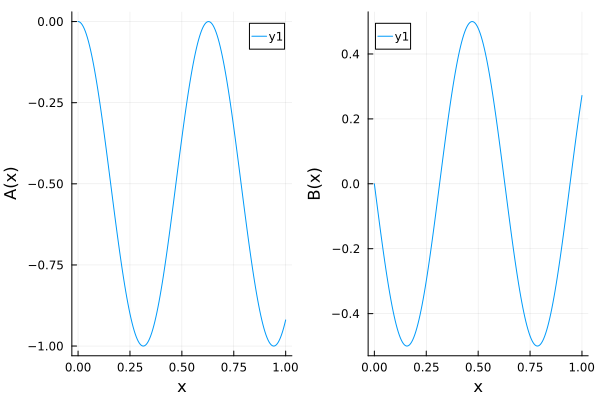

In [77]:
# plot u(x) and du/dx(x)
myA = [u[1] for u in sol.u]
myB = [u[2] for u in sol.u]
p1 = plot(sol.t, myA, xlabel="x", ylabel = "A(x)") 
p2 = plot(sol.t, myB, xlabel="x", ylabel = "B(x)") 
plot(p1,p2,layout=(1,2))

### Section 4.2: Plot solution in space-time domain 

Construct solution in time domain by outer product of two vectors, one in space, the other in time. 

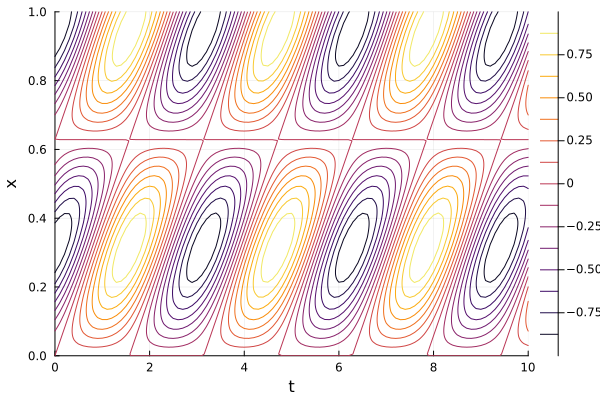

In [78]:
tend = 10; tstep = 0.1; 
tvec = 0:tstep:tend |> collect
ucost = cos.(omd*tvec); usint = sin.(omd*tvec)
U = myA*ucost' - myB*usint'
contour(tvec,sol.t,U,xlabel="t",ylabel="x")

## Section 2: Analytical Reference Solution for Linear Equation without External Forcing 

To do:   
1. plot the wave travelling in opposite direction;
1. plot the wave with anti-periodic boundary conditions; 

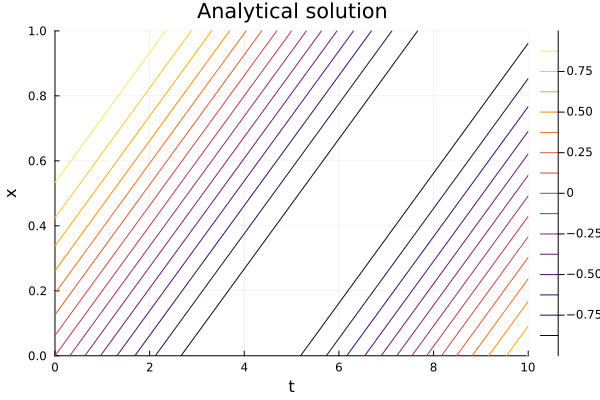

In [61]:
function sineWave(x,t,p)
    c, omd = p 
    xi = x-c*t
    return sin(omd*xi)
end 

function gaussWave(x,t,p)
    c, omd = p
    xi = x-c*t
    return exp(-(xi-.2)^2/0.01)
end 

# set number of elements in space, the number of time samples and number of modes 
nelements = 100
Nt = 1000

#..construct the 1D spatial x-mesh and the spatial modes 
nnodes = nelements+1; h = 1/nelements; h2=h*h; 
x = Vector(0:h:1); 

#..construct temporal t-mesh  
Tend = 10; dt = Tend/Nt; 
t = Vector(0:dt:Tend);

#..set wave velocity and damping coefficients 
c   = .2
omd = 2
p   = [c, omd]

#..initialize and construct analytical solution 
uanal = [sineWave(xi,tj,p) for xi in x, tj in t]

p1 = contour(t,x,uanal,xlabel="t",ylabel="x",title="Analytical solution")

plot(p1)

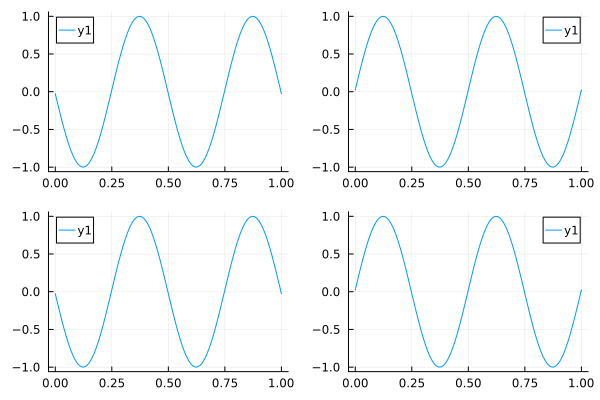

In [23]:
# plot time traces 
p1 = plot(x,uanal[:,Int64(Nt/8)])
p2 = plot(x,uanal[:,Int64(2*Nt/8)])
p3 = plot(x,uanal[:,Int64(3*Nt/8)])
p4 = plot(x,uanal[:,Int64(4*Nt/8)])
p5 = plot(x,uanal[:,Int64(5*Nt/8)])
p6 = plot(x,uanal[:,Int64(6*Nt/8)])
p7 = plot(x,uanal[:,Int64(7*Nt/8)])
p8 = plot(x,uanal[:,Int64(8*Nt/8)])
plot(p1,p2,p3,p4,layout=(2,2))
#plot(p5,p6,p7,p8,layout=(2,2))

## Section 3: Spatial Discretization: Construct the One-Dimensional Advection Matrix

1. using periodic boundary conditions, the linear algebra on a mesh with N+1 nodes leads to a linear system of size N-by-N. We omit the last node in the mesh. 
1. need to add upwind scheme? 
1. Implement backward difference scheme. 

In [80]:
# struct to hold entire mesh
struct Mesh
  #..number of nodes of the mesh..   
  nnodes::Int64
  #..number of elements of the mesh..
  nelements::Int64 
  #..vector of x-coordinates of nodes of the mesh..
  nodes::Vector{Float64}
  #..vector of x-coordinates of nodes of the mesh..
  midpoints::Vector{Float64}    
end 

# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    nodes = Vector{Float64}(0:h:1) 
    midpoints = nodes[1:end-1] + (nodes[2:end] - nodes[1:end-1])/2
    mesh = Mesh(nnodes,nelements,nodes,midpoints)     
    return mesh;
end 

# generate N-by-N advection matrix by backward difference scheme with mesh width h
# leading to lower (L) bi-diagonal matrix 
function genAdvMatL(mesh::Mesh)

    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes    = nelements+1
    
    #..set mesh width and square of mesh width 
    h = 1/nelements

    #..construct the advection matrix\ 
    e = ones(nnodes) 
    A = Bidiagonal(e, -e[2:end], :L)
    A = (1/h)*A     
   
    return A;     
end

# generate load vector of size N 
function genVector(mesh, sourceFct::F) where F 

    #..recover mesh nodes  
    nodes = mesh.nodes
    
    #..set vector values using broadcasting (dot syntax)  
    f = sourceFct.(nodes[1:end])
   
    return f; 
end

function genBoundariesL!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements
    
    A = sparse(A)
    # A[1,end] = -1/h   
    A[1,1] = 1.; A[1,2] = 0.

    return A,f   
end

function genBoundariesU!(mesh,A,f)
    
    #..recover number of elements and nodes  
    nelements = mesh.nelements
    nnodes = mesh.nnodes 
    
    #..set mesh width and square of mesh width 
    h = 1/nelements
    
    A = sparse(A)
    A[end,1] = 1/h   

    return A,f   
end

genBoundariesU! (generic function with 1 method)

Test above on small mesh. 

In [81]:
nelements = 4
mesh = genMesh(nelements)
myfct(x) = 0 
A = genAdvMatL(mesh); f = genVector(mesh, myfct) 
A,f = genBoundariesL!(mesh,A,f);
display(A)
#display(f)

5×5 SparseMatrixCSC{Float64, Int64} with 9 stored entries:
  1.0    ⋅     ⋅     ⋅    ⋅ 
 -4.0   4.0    ⋅     ⋅    ⋅ 
   ⋅   -4.0   4.0    ⋅    ⋅ 
   ⋅     ⋅   -4.0   4.0   ⋅ 
   ⋅     ⋅     ⋅   -4.0  4.0

## Section 4: Time Integration of the Linear Problem

We study three scenarios: 
1. propagation of a Gaussian wave: no external forcing and initial solution given by Gauss wave at $t=0$; 
1. propagation of a sine wave: as above with initial sinus wave; 
1. periodically driven source term: sinusoidally driven source term, not sure about the initial guess: what happens when increasing driving frequency or amplitude of the driving force?  

In [88]:
nelements = 1000
mesh = genMesh(nelements)
myfct(x) = 0 
J0 = genAdvMatL(mesh); f = genVector(mesh, myfct) 
J0,f = genBoundariesL!(mesh,J0,f);
f[1] = 1.; 

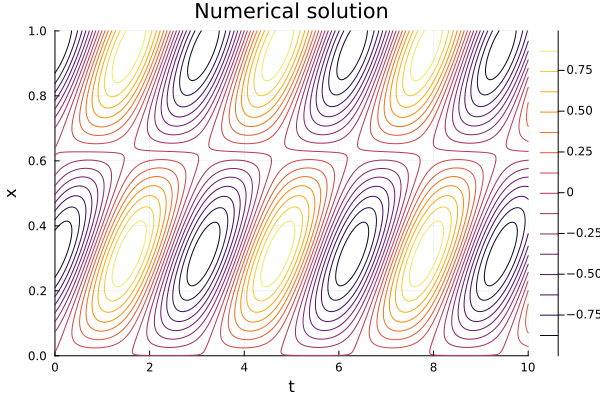

In [89]:
function no_external_forcing!(du,u,p,t)
    c, omd = p 
    du .= -c*J0*u 
end
 
function sinusoidal_forcing!(du,u,p,t)
    c, omd = p 
    du .= -c*(J0*u) .+ 1.0*sin(omd*t)
    du[1] = 0 
end

# set constants 
c = 0.2
omd = 2.

# store parameter value in p  
p = [c, omd]

# u0 = [0. for xi in mesh.nodes
# u0 = [gaussWave(xi,0,p) for xi in mesh.nodes]
# u0 = [sineWave(xi,0,p) for xi in mesh.nodes]
u0 = [solbvp(xi)[1] for xi in mesh.nodes]

tspan = (0.0,10)

prob = ODEProblem(sinusoidal_forcing!,u0,tspan,p)
sol = solve(prob, alg_hints = [:stiff], reltol = 1e-8, abstol = 1e-8, save_everystep = true);

# post processing 
posind = 1:(mesh.nnodes) 
myU = sol[posind,:]
p1  = contour(sol.t,mesh.nodes,myU,xlabel="t",ylabel="x")
title!("Numerical solution")

## Section 5:  Time Integration of the Linear Problem

What initial solution to provide? Should non-linearity be ramped in time? 

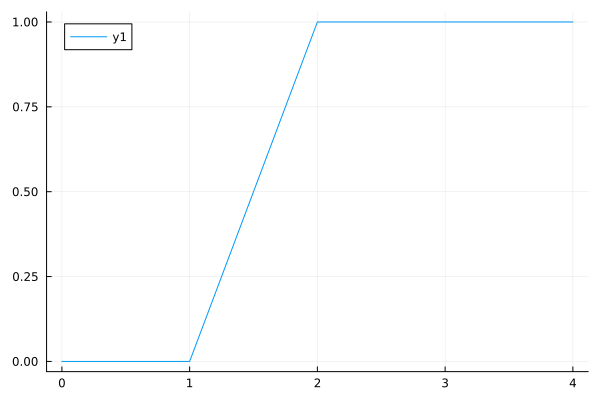

In [101]:
ramp(t) = (t-1)*((t>=1)) - (t-2)*((t>=2)) 

tvec = 0:01:4 

plot(tvec,ramp.(tvec))

In [121]:
function sinusoidal_forcing!(du,u,p,t)
    c, omd = p 
    # du .= -c*(J0*u) .- 0.1*ramp(t)*u.*(J0*u) .+ 1.0*sin(omd*t)
    du .= -c*(J0*u) .- 0.01*ramp(t)*u.*(J0*u) .+ 1.0*sin(omd*t)
    du[1] = 0 
end

# set constants 
c = 0.2
# omd = 2.
omd = 5.

# store parameter value in p  
p = [c, omd]

# initial solution 
u0 = [solbvp(xi)[1] for xi in mesh.nodes]

tspan = (0.0,50)

prob = ODEProblem(sinusoidal_forcing!,u0,tspan,p)
sol = solve(prob, alg_hints = [:stiff], reltol = 1e-8, abstol = 1e-8, save_everystep = true);

# post processing 
posind = 1:(mesh.nnodes) 
myU = sol[posind,:]
p1  = contour(sol.t,mesh.nodes,myU,xlabel="t",ylabel="x")

## Section 6: Spectral Analysis for Time Traces 

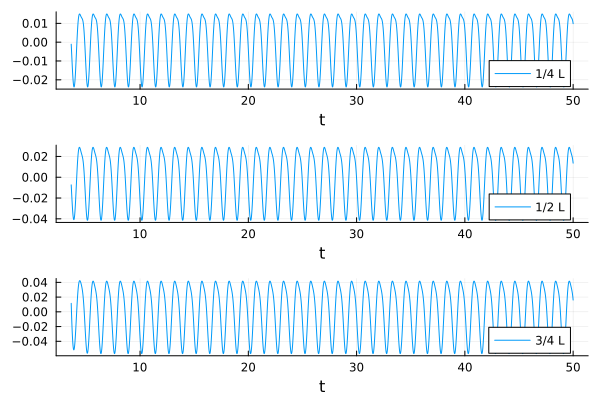

In [139]:
up1 = myU[nelements÷4,:]
up2 = myU[nelements÷2,:]
up3 = myU[3*nelements÷4,:]

myfirst = 800 
p1 = plot(sol.t[myfirst:end],up1[myfirst:end],xlabel="t",label="1/4 L")
p2 = plot(sol.t[myfirst:end],up2[myfirst:end],xlabel="t",label="1/2 L")
p3 = plot(sol.t[myfirst:end],up3[myfirst:end],xlabel="t",label="3/4 L")
plot(p1,p2,p3,layout=(3,1)) 

In [140]:
# perform FFT of sampled position data 
ufp1 = fft(up1[myfirst:end])
ufp2 = fft(up2[myfirst:end])
ufp3 = fft(up3[myfirst:end]);

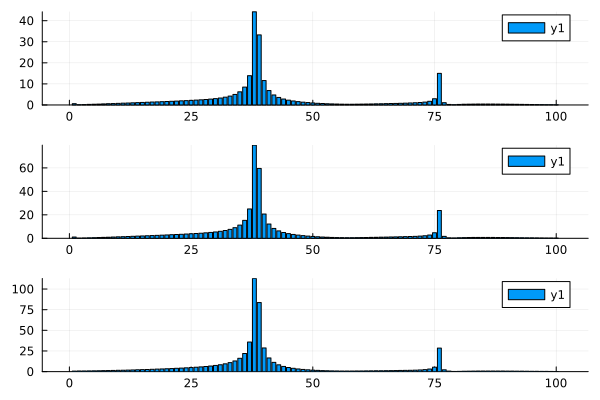

In [142]:
last = 100 
p1 = bar(abs.(ufp1)[1:last])
p2 = bar(abs.(ufp2)[1:last])
p3 = bar(abs.(ufp3)[1:last])
plot(p1,p2,p3,layout=(3,1))

In [ ]:
# perform FFT of sampled position data 
ufp1 = fft(up1)
ufp2 = fft(up2)
ufp3 = fft(up3)

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nt
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nt * abs.(unumfp3[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(unumfp3[1:length(fvec)]),label="phase")
plot(p1, p2)

## References 